In [6]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors._dist_metrics import DistanceMetric
from torch.utils.data import DataLoader, Subset

from datasets.embeddings_localization_dataset import EmbeddingsLocalizationDataset
from torchvision.transforms import transforms

from datasets.transforms import SolubilityToInt
from utils.general import numpy_collate_for_reduced

train_embeddings = 'data/embeddings/train_reduced.h5'
val_embeddings = 'data/embeddings/val_reduced.h5'
test_embeddings = 'data/embeddings/test_reduced.h5'
train_remapping = 'data/embeddings/train_remapped.fasta'
val_remapping = 'data/embeddings/val_remapped.fasta'
test_remapping = 'data/embeddings/test_remapped.fasta'

transform = transforms.Compose([SolubilityToInt()])
train_set = EmbeddingsLocalizationDataset(train_embeddings, train_remapping, max_length=6000, transform=transform)
val_set = EmbeddingsLocalizationDataset(val_embeddings, val_remapping, transform=transform)

train_loader = DataLoader(train_set, batch_size=len(train_set), collate_fn=numpy_collate_for_reduced)
val_loader = DataLoader(val_set, batch_size=len(val_set), collate_fn=numpy_collate_for_reduced)

train_data = next(iter(train_loader))  # tuple of embedding, localization, solubility, metadata
val_data = next(iter(val_loader))  # tuple of embedding, localization, solubility, metadata
classifier = KNeighborsClassifier(n_neighbors=1, p=1)
classifier.fit(train_data[0], train_data[1])


KNeighborsClassifier(n_neighbors=1, p=1)

In [7]:
predictions = classifier.predict(val_data[0])
distances, _ = classifier.kneighbors(val_data[0])
#distances = np.array(distances).sum(-1).squeeze()

In [8]:
import matplotlib
from torch.utils.data import DataLoader, Subset
import seaborn as sns
sns.set_theme()
import pandas as pd
import matplotlib.pyplot as plt
accuracy_threshold= 0.8
#matplotlib.rcParams['figure.dpi'] = 300

len validation set : 1158
len of dataset for which no high accuracy predictions were possible : 798


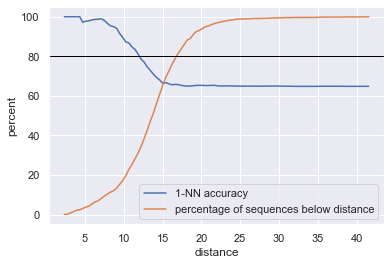

In [31]:

cutoffs = np.linspace(distances.min(),distances.max(),100)
results = np.array([predictions,val_data[1], distances.squeeze()]).T
accuracies = []
number_sequences = []
lower_accuracy_found = False
low_accuracy_mask = np.ones(len(results))
for cutoff in cutoffs:
    indices = results[:, 2] <= cutoff
    below_cutoff = results[results[:, 2] <= cutoff]
    accuracy = np.equal(below_cutoff[:, 0], below_cutoff[:, 1]).sum() / len(below_cutoff)
    accuracies.append(accuracy*100)
    if accuracy <= accuracy_threshold:
        lower_accuracy_found = True
    if accuracy >= accuracy_threshold and not lower_accuracy_found:
        high_accuracy_predictions = below_cutoff
        low_accuracy_mask = np.invert(indices)
    number_sequences.append(len(below_cutoff))

val_kept = Subset(val_set,np.where(low_accuracy_mask)[0])
print('len validation set :', len(val_set))
print('len of dataset for which no high accuracy predictions were possible :', len(val_kept))
df = pd.DataFrame(np.array([cutoffs,accuracies, 100*np.array(number_sequences)/len(val_set)]).T, columns=["distance", "accuracy", 'percentage_sequences'])
df = df.melt('distance', var_name='cols',  value_name='percent')
sns.lineplot(x="distance", y="percent", hue='cols', data=df)
plt.legend(labels=['1-NN accuracy', 'percentage of sequences below distance'])
plt.axhline(y=80,linewidth=1, color='black')


